In [1]:
import numpy as np
import pandas as pd
import re

data_calendar = pd.read_csv('../Data/calendar.csv')
listings_full = pd.read_csv('../Data/listings_full.csv')

# =============================================================================
# calendar
# =============================================================================

na_column = data_calendar.apply(lambda x: sum(x.isnull()), axis = 0)

def num_na(x):
    return sum(x.isnull())
na_by_id = (data_calendar
     .groupby('listing_id')
     .agg(
        num_price_na = ('price', num_na),
        num_adj_price_na = ('adjusted_price', num_na),
        num_min_night_na = ('minimum_nights', num_na),
        num_max_night_na = ('maximum_nights', num_na)
     ))

has_na_listing_id = na_by_id[na_by_id.apply(lambda x: any(x.iloc[0:4]), axis = 1)]

price_na_listing_id = na_by_id[(na_by_id['num_price_na'] > 0) | (na_by_id['num_adj_price_na'] > 0)].index

# five listings have missing data, the number of rows with missing data is around 170, almost half the 365 days,
# therefore, we delete the record of this 5 listings
len(price_na_listing_id)
data_calendar = data_calendar[~data_calendar['listing_id'].isin(price_na_listing_id)]

def to_num(x):
    x = re.sub(r',', '', x)
    return float(x[1:])
data_calendar['price'] = list(map(to_num, data_calendar['price']))
data_calendar['adjusted_price'] = list(map(to_num, data_calendar['adjusted_price']))

calendar_summary = (
        data_calendar
        .groupby('listing_id')
        .agg({
            'available': lambda x: sum(x == 't') / len(x),
            'price': np.mean,
            'adjusted_price': np.mean,
            'minimum_nights': np.mean,
            'maximum_nights': np.mean
        }))

calendar_summary = calendar_summary.reset_index()
calendar_summary.rename(columns = {'price':'price_avrg', 'adjusted_price':'adjusted_price_avrg'}, inplace=True)



# =============================================================================
# Listing
# =============================================================================

percent_NA = listings_full.isnull().sum() * 100 / len(listings_full)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
NA_info[NA_info["percent_NA"]>5]

col_many_na = percent_NA[percent_NA > 60].index
listings_full.drop(col_many_na, axis = 1, inplace = True)

#col_var = {}
#for i in listings_full.columns:
#    col_var[i] = len(np.unique(listings_full[i]))

col_to_del = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered',
              'picture_url', 'host_url', 'country_code', 'country', 'calendar_last_scraped']
listing1 = listings_full.drop(col_to_del, axis = 1)


percent_NA = listing1.isnull().sum() * 100 / len(listing1)
col_w_na = percent_NA[percent_NA > 0].index

# =============================================================================
# numeric variable
# =============================================================================

# convert $ into number
def to_num(x):
    x = re.sub(r',', '', x)
    return float(x[1:])

listing1['price'] = list(map(to_num, listing1['price']))
valid_ind_security = ~listing1['security_deposit'].isnull()
listing1.loc[valid_ind_security, 'security_deposit'] = list(
        map(to_num, listing1.loc[valid_ind_security, 'security_deposit']))
valid_ind_clean = ~listing1['cleaning_fee'].isnull()
listing1.loc[valid_ind_clean, 'cleaning_fee'] = list(
        map(to_num, listing1.loc[valid_ind_clean, 'cleaning_fee']))
listing1['extra_people'] = list(map(to_num, listing1['extra_people']))

def str_to_pct(x):
    x = re.sub(r'%', '', x)
    return float(x) / 100
valid_ind_host= ~listing1['host_response_rate'].isnull()
listing1.loc[valid_ind_host, 'host_response_rate'] = list(
        map(str_to_pct, listing1.loc[valid_ind_host, 'host_response_rate']))

# numeric col with na
num_col_w_na = [
        'host_response_rate', 'host_listings_count', 'host_total_listings_count',
        'bathrooms', 'bedrooms', 'beds', 'security_deposit',
        'cleaning_fee', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']
mean_na_col = {}
for col in num_col_w_na:
    mean_na_col[col] = np.mean(listing1[col])

for col_name in num_col_w_na:
    na_row_ind = listing1[col_name].isnull()
    listing1.loc[na_row_ind, col_name] = mean_na_col[col_name]

# =============================================================================
# Qualitative Variable
# =============================================================================
#cat_col = ['host_response_time', 'host_neighbourhood', 'host_has_profile_pic',
#           'host_is_superhost', 'host_identity_verified', 'neighbourhood',
#           'city', 'state', 'market']
qualtv_col = col_w_na[~col_w_na.isin(num_col_w_na)]
for col_name in qualtv_col:
    na_row_ind = listing1[col_name].isnull()
    listing1.loc[na_row_ind, col_name] = 'Unknown'

# for columns of word description, i.e. non-categorical variables,
# convert them into binary variable of having content vs. not
col_to_binary = ['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_name',
       'host_location', 'host_about', 'host_thumbnail_url',
       'host_picture_url', 'zipcode', 'first_review', 'last_review']
for col in col_to_binary:
    binary_col_name = 'has_' + col
    listing1[binary_col_name] = (listing1[col] != 'Unknown').astype(int)

#listing1.to_csv("listing_clean.csv", index = False)





# =============================================================================
# combine
# =============================================================================

listing1.shape
calendar_summary.shape


sum(listing1['id'].isin(calendar_summary['listing_id']))
sum(calendar_summary['listing_id'].isin(listing1['id']))

listing_calendar = pd.merge(listing1, calendar_summary, 'inner',
                            left_on = 'id', right_on = 'listing_id')
listing_calendar.drop('listing_id', axis = 1, inplace = True)

#listing_calendar.to_csv("listing_calendar_clean.csv", index = False)



/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
model_data = listing_calendar.copy()

In [3]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud, STOPWORDS
from re import sub

In [4]:
#listings = pd.read_csv('../Data/listings.csv') 
#reviews = pd.read_csv('../Data/reviews.csv')
reviews_full = pd.read_csv('../Data/reviews_full.csv')
#listings_full = pd.read_csv('../listings_full.csv')
#neighborhood = pd.read_csv('../Data/neighbourhoods.csv')
#calendar = pd.read_csv('../calendar.csv')
#model_data = pd.read_csv('../../listing_calendar_clean.csv')

In [5]:
## drop observations in the datset with no reviews
reviews_full = reviews_full.dropna(subset=["comments"]).copy()

In [6]:
## count the length of a review in terms of number of words
def count_words(string):
    return len(string.split())

reviews_full["nwords"] = reviews_full["comments"].apply(count_words)

In [7]:
## returns the proportion of punctuation marks in the comment
def prop_punc(input_str):
    return len(re.findall(f"[{string.punctuation}]", input_str))/len(input_str)

reviews_full["punc_prop"] = reviews_full["comments"].apply(prop_punc)

In [8]:
def excl(input_str):
    return int(len(re.findall("!!(.*)", input_str))>0)

reviews_full[">2_exclamation"] = reviews_full["comments"].apply(excl)

In [9]:
upper = re.compile('[A-Z]')

def prop_cap(input_str):
    return len(upper.findall(input_str))/len(input_str)

reviews_full["prop_cap"] = reviews_full["comments"].apply(prop_cap)

In [10]:
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,nwords,punc_prop,>2_exclamation,prop_cap
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,123,0.029703,0,0.032532
1,2595,19176,2009-12-05,53267,Cate,Great experience.,2,0.058824,0,0.058824
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,90,0.033970,0,0.036093
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",66,0.038251,0,0.024590
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,24,0.025806,0,0.038710


In [11]:
## group by listing, get the feature means across reviews for each listing 

reviews_summary = (
        reviews_full
        .groupby('listing_id')
        .agg({
            'nwords': np.mean,
            'punc_prop': np.mean,
            '>2_exclamation': np.mean,
            'prop_cap': np.mean
        }))

In [12]:
## confirm no missing data
model_data.isnull().sum()

id                     0
name                   0
summary                0
space                  0
description            0
                      ..
available              0
price_avrg             0
adjusted_price_avrg    0
minimum_nights_y       0
maximum_nights_y       0
Length: 112, dtype: int64

In [13]:
data = pd.merge(model_data, reviews_summary, 'inner',
                            left_on = 'id', right_on = 'listing_id')

In [14]:
## Convert host_response_rate to quantititave

data['host_response_rate'] = data["host_response_rate"].astype(float)

## Use this variable instead of host_since to have fewer levels
data["host_since_year"] = data["host_since"].apply(lambda x: x[0:4])

## Transform host_verifications (ex. email, phone) into total number of means of verification
data["host_verifications_count"] = data["host_verifications"].apply(lambda x: x[1:-1]).apply(lambda x: x.split(',')).apply(lambda x: len(x))

## clean the messy "amenities" feature: length of amenities description in characters
data['amenities_length'] = data['amenities'].apply(lambda x: len(x))

## Include These Categorical Variables in Model

host_response_time (though it may be highly correlated with host response rate)
            
host_is_superhost 
            
neighbourhood_cleansed 
            
neighbourhood_group_cleansed 
            
is_location_exact 
            
property_type
            
room_type
            
bed_type
            
amenities: very messy. Use nchars?
            
instant_bookable
            
cancellation_policy
            
require_guest_profile_picture
            
require_guest_phone_verification

and any categorical variables you cleaned before


In [15]:
## split dataset into quantitative variables and categorical variable

float_vars = data.loc[:, data.dtypes == 'float64']
int_vars = data.loc[:, data.dtypes == 'int64']
quantitative_vars = pd.concat([float_vars, int_vars], axis=1)
categorical_vars = data.loc[:, data.dtypes == object]

In [16]:
quantitative_features = quantitative_vars.columns.values
categorical_features = ['host_response_time', 'host_is_superhost', 'neighbourhood_cleansed',
                        'neighbourhood_group_cleansed', 'is_location_exact', 'property_type',
                        'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy',
                        'require_guest_profile_picture', 'require_guest_phone_verification',
                        'host_since_year']

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy as sp
from sklearn import preprocessing

In [18]:
## normalize quantative features being fitting model
quantitative_vars_normalized = quantitative_vars.apply(lambda x: preprocessing.scale(x), axis = 0)

exclude_these = ["price", 'price_avrg', 'adjusted_price_avrg']
use_these = [x for x in quantitative_vars_normalized.columns if x not in exclude_these]

quant_exclude_price = quantitative_vars_normalized.loc[:, use_these]

In [19]:
## create dummy variables for categorical features
def dummy_df(df, feature_names):
    dummydf = pd.DataFrame()
    for name in feature_names:
        tmp = pd.get_dummies(df.loc[:,name], prefix= name, prefix_sep='_')
        dummydf = pd.concat([dummydf, tmp], axis = 1)
    return dummydf

dummy_vars = dummy_df(categorical_vars, categorical_features)

In [20]:
lasso_data = pd.concat([quant_exclude_price, dummy_vars], axis = 1)
price = quantitative_vars_normalized.loc[:, "price"]

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha': np.arange(.01, 1, .01)}

In [29]:
np.random.seed(seed=1000)
lasso_gridcv = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5, )
lasso_gridcv.fit(lasso_data, price)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_

In [30]:
print(lasso_gridcv.best_params_)
print(lasso_gridcv.best_score_)

{'alpha': 0.01}
-0.9479142006399199


In [31]:
## fit the model now with the optimal tuning parameter
lassoreg = Lasso(alpha=.01, max_iter=1e5)
lassoreg.fit(lasso_data, price)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

4.068129015762168e-17


Text(0.5, 1.0, 'Residuals Plot')

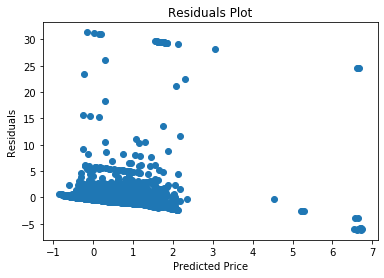

In [35]:
preds = lassoreg.predict(lasso_data)
residuals = price - preds

print(np.mean(residuals))

plt.scatter(preds, residuals)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

In [36]:
A = lasso_data.columns[lassoreg.coef_ != 0]

In [37]:
B = lassoreg.coef_[lassoreg.coef_ != 0]

In [38]:
tmp_df = pd.DataFrame({"Features": A, "Coefficients": B})

In [47]:
tmp_df.sort_values(by=['Coefficients'], ascending=False).reset_index().loc[:, ["Features", "Coefficients"]][18:37]

,Features,Coefficients
18,has_host_about,0.002310
19,maximum_nights_avg_ntm,0.001703
20,nwords,0.001649
21,maximum_maximum_nights,0.000454
22,has_notes,-0.003449
23,host_response_rate,-0.005086
24,number_of_reviews,-0.006975
25,calculated_host_listings_count,-0.009975
26,review_scores_communication,-0.011754
27,has_transit,-0.012162


In [ ]:

## np.array(price).reshape(-1,1)
## transform predictions back to scale and find RMSE
#sd = np.std(data.loc[:, "price"])
#mean = np.mean(data.loc[:, "price"])
#y_pred = lassoreg.predict(price)

In [ ]:
data.loc[:, "minimum_maximum_nights"]

In [ ]:
#all_columns = "+".join(quantitative_vars.columns - ["price"])

def ols_formula(dependent_var, quantitative, categorical, *exclude):

    #quantitative.remove(dependent_var)
    tmp = lambda x: "C(" + x + ")"
    categoricalC = list(map(tmp, categorical))
    for x in exclude:
        quantitative.remove(x)
    return dependent_var + ' ~ ' + ' + '.join(quantitative) + ' + ' + ' + '.join(categoricalC)

## alternatively: use pandas_getdummies to get dummy variables, and then use sklearn

In [ ]:
lasso_data = pd.concat([quant_exclude_price, categorical_vars], axis = 1)
fml = ols_formula('price', use_these, categorical_features)
mod = sm.OLS.from_formula(fml, lasso_data)
rslt = mod.fit_regularized(alpha=.005)

In [ ]:
rslt.params[rslt.params != 0]

# Issues
    1. "has_availability": what does this mean?
    2. is_business_travel_ready: what does this mean?
    3. extend to group lasso later
    4. Include all categorical variables in initial model